In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('News.csv',index_col=0)
data.head(50)
data.shape

(44919, 5)

In [5]:
data.shape

(44919, 5)

In [6]:
data = data.drop(["title", "subject","date"], axis = 1)

In [7]:
data.isnull().sum()

text     0
class    0
dtype: int64

In [8]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

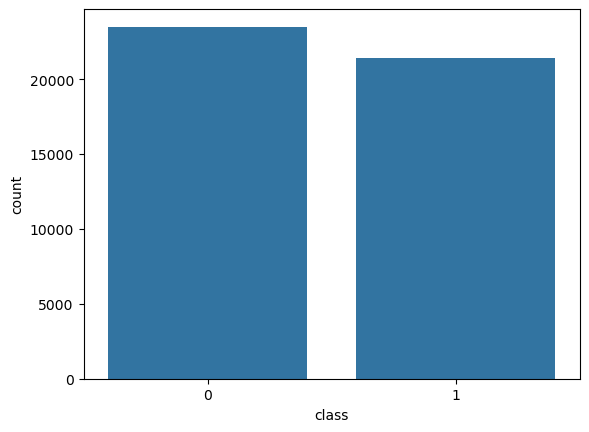

In [9]:
sns.countplot(data=data,
			x='class',
			order=data['class'].value_counts().index)

In [10]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

In [13]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [1:19:00<00:00,  9.48it/s]    


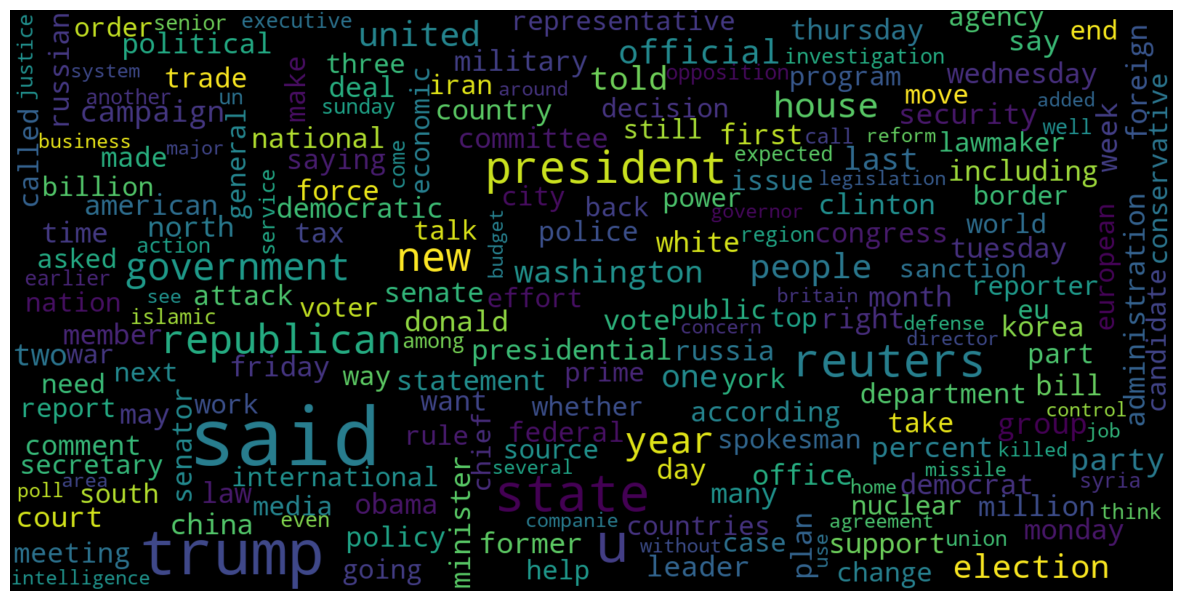

In [14]:
# Real
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

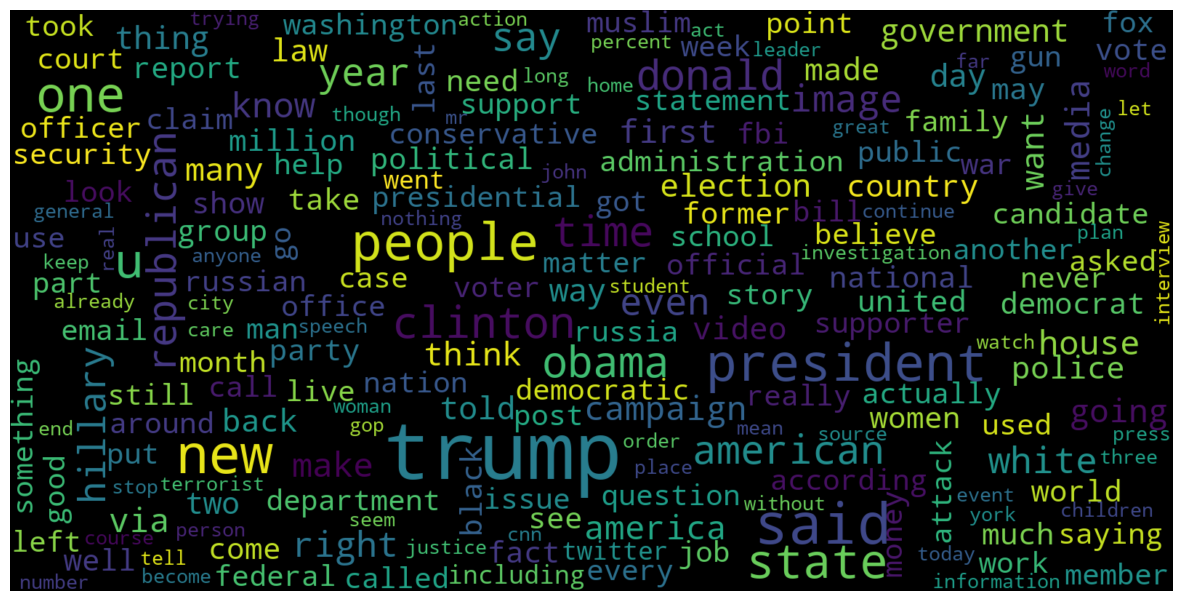

In [15]:
# Fake
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

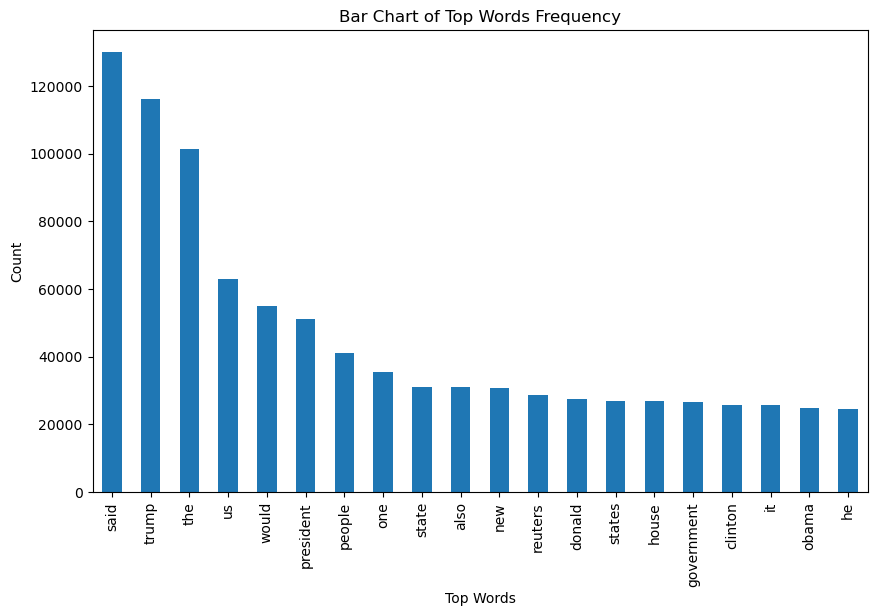

In [16]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
	vec = CountVectorizer().fit(corpus)
	bag_of_words = vec.transform(corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['text'],
													data['class'],
													test_size=0.25)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9937071447653537
0.990026714158504


In [20]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

1.0
0.9948352626892253


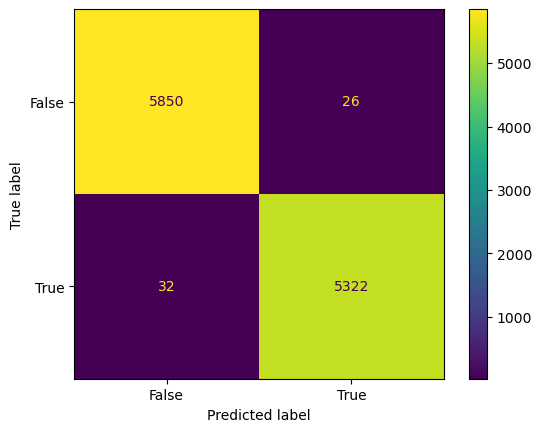

In [22]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()

In [47]:
# Define the prediction function
from sklearn.tree import DecisionTreeClassifier

# Train the Decision Tree model
tree_model = DecisionTreeClassifier()
tree_model.fit(x_train, y_train)

def predict_news(input_text, model, vectorizer):
    # Preprocess the input text
    input_data = preprocess_text([input_text])
    
    # Transform the text using the fitted TfidfVectorizer
    input_vector = vectorizer.transform(input_data)
    
    # Make a prediction
    prediction = model.predict(input_vector)

    # Interpret the prediction
    if prediction[0] == 1:
        print("The news article is predicted to be: Real")
    else:
        print("The news article is predicted to be: Fake")

# Example usage with a trained model (Decision Tree model in this case)
input_text = input("Enter a news article text to check if it is Real or Fake:\n")
predict_news(input_text, tree_model, vectorization)


Enter a news article text to check if it is Real or Fake:
 "BREAKING: Scientists confirm that the Earth is flat and all previous reports were part of a government conspiracy."


100%|██████████| 1/1 [00:00<00:00, 211.58it/s]

The news article is predicted to be: Fake
